<a href="https://colab.research.google.com/github/isj0/DeepLearning/blob/main/Project_02_CIFAR_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# install required libraries - Captum
!pip install captum

In [46]:
# import required libraries

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import IntegratedGradients, Saliency
from captum.attr import visualization as viz
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [47]:
# define transformation for images
transform = transforms.ToTensor()

In [48]:
# Load the CIFAR-100 training and test dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)


In [49]:

# dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 50000
Test dataset size: 10000


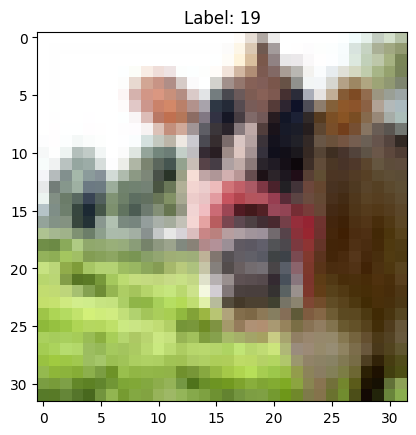

In [50]:
# inspect dataset
image, label = train_dataset[0]

img = image.numpy().transpose((1, 2, 0))

# plot the image
plt.imshow(img)
plt.title(f"Label: {label}")
plt.show()

In [51]:
# create dataloaders for batch training

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [52]:
# get one batch from training dataloader
images, labels = next(iter(train_loader))

# list of class names (100 classes)
classes = train_dataset.classes

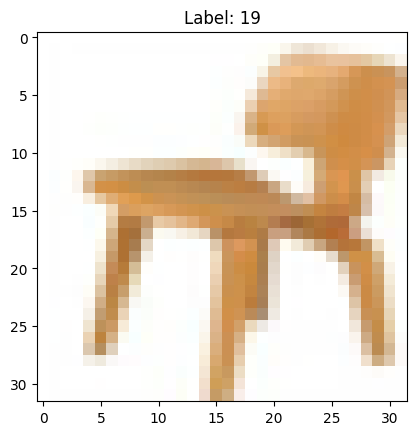

In [53]:
# visualize the first image in the batch
img = images[0].numpy().transpose((1, 2, 0))
# plot the image
plt.imshow(img)
plt.title(f"Label: {label}")
plt.show()

In [54]:
# device set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [55]:
# calculate accuracy

def calculate_accuracy(y_pred, y_true):
    # class with the highest probability
    predicted = torch.argmax(y_pred, dim = 1)

    # count correct predictions
    correct = (predicted == y_true).sum().item()

    return correct / len(y_true)


In [56]:
# training function

def train_one_epoch(model, dataloader, loss_fn, optimizer):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for images, labels in dataloader:
        # move the data to the GPU
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)

        # calculate loss
        loss = loss_fn(outputs, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()     # compute gradients
        optimizer.step()    # update weights

        # metrics
        running_loss += loss.item()
        running_acc += calculate_accuracy(outputs, labels)

    # return average loss and accuracy
    return running_loss / len(dataloader), running_acc / len(dataloader)

In [57]:
# testing function

def evaluate(model, dataloader, loss_fn):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item()
            running_acc += calculate_accuracy(outputs, labels)

    return running_loss / len(dataloader), running_acc / len(dataloader)

In [58]:
# Confusion matrix

def plot_confusion_matrix(model, test_loader, class_names, title = "Confusion Matrix"):

    # model must be in evaluation mode
    model.eval()

    # list to store all predictions and true labels
    all_preds = []
    all_labels = []

    # disable gradient computation
    with torch.no_grad():
        for images, labels in test_loader:
            # move images and labels to GPU
            images = images.to(device)
            labels = labels.to(device)

            # forward pass: get the model outputs
            outputs = model(images)

            # get the predicted class
            _, preds = torch.max(outputs, 1)

            # store predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # compute confusion matrix using sklearn
    cm = confusion_matrix(all_labels, all_preds)

    # display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(20, 20))
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title(title)
    plt.show()

In [59]:
# Evaluate test accuracy and plot confusion matrix

def evaluate_and_plot(model, test_loader, classes, title="Confusion Matrix"):

    # calculate test loss & acccuracy
    loss_fn = nn.CrossEntropyLoss()
    test_loss, test_acc = evaluate(model, test_loader, loss_fn)

    # display test accuracy and loss
    print(f"Test Accuracy for {title}: {test_acc*100:.2f}")
    print(f"Test Loss for {title}: {test_loss:.4f}")

    # now lets plot the confusion matrix
    plot_confusion_matrix(model, test_loader, classes, title)

### a) Design a deep neural network (DNN) (at least 3 fully connected neural network) for the CIFAR-100 dataset

In [60]:
# DNN model

class CIFAR100_DNN(nn.Module):
    def __init__(self):
        super(CIFAR100_DNN, self).__init__()

        # flatten layer - input images into 1D vector of length 3072
        self.flatten = nn.Flatten()

        # fully connected deep NN - 3 layers & output
        self.fc = nn.Sequential(
            nn.Linear(3 * 32 * 32, 1024),    # layer 1
            nn.ReLU(),

            nn.Linear(1024, 512),            # layer 2
            nn.ReLU(),

            nn.Linear(512, 256),             # layer 3
            nn.ReLU(),

            nn.Linear(256, 100)             # output layer - 100 classes

        )

    def forward(self, x):
        # flatten image into a vector
        x = self.flatten(x)
        # pass through fully connected layers
        x = self.fc(x)
        return x

In [61]:
# create model, loss and optimizer

model_dnn = CIFAR100_DNN().to(device)
loss_fn_dnn = nn.CrossEntropyLoss()
optimizer_dnn = optim.Adam(model_dnn.parameters(), lr = 0.001)

In [62]:
# Train the model for several epochs

train_acc_list_dnn = []
test_acc_list_dnn = []

# full passes through training dataset
EPOCHS =10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model_dnn, train_loader, loss_fn_dnn, optimizer_dnn)
    test_loss, test_acc = evaluate(model_dnn, test_loader, loss_fn_dnn)

    # record train/test accuracies for each epoch
    train_acc_list_dnn.append(train_acc)
    test_acc_list_dnn.append(test_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    print("-----------------------------------------------------")


Epoch 1/10
Train Loss: 4.1282, Train Accuracy: 0.0611
Test Loss: 3.9424, Test Accuracy: 0.0853
-----------------------------------------------------
Epoch 2/10
Train Loss: 3.7891, Train Accuracy: 0.1141
Test Loss: 3.6525, Test Accuracy: 0.1414
-----------------------------------------------------
Epoch 3/10
Train Loss: 3.5899, Train Accuracy: 0.1483
Test Loss: 3.5854, Test Accuracy: 0.1575
-----------------------------------------------------
Epoch 4/10
Train Loss: 3.4717, Train Accuracy: 0.1703
Test Loss: 3.5624, Test Accuracy: 0.1575
-----------------------------------------------------
Epoch 5/10
Train Loss: 3.3788, Train Accuracy: 0.1858
Test Loss: 3.4917, Test Accuracy: 0.1698
-----------------------------------------------------
Epoch 6/10
Train Loss: 3.3034, Train Accuracy: 0.1975
Test Loss: 3.3992, Test Accuracy: 0.1894
-----------------------------------------------------
Epoch 7/10
Train Loss: 3.2343, Train Accuracy: 0.2116
Test Loss: 3.3696, Test Accuracy: 0.1938
-----------

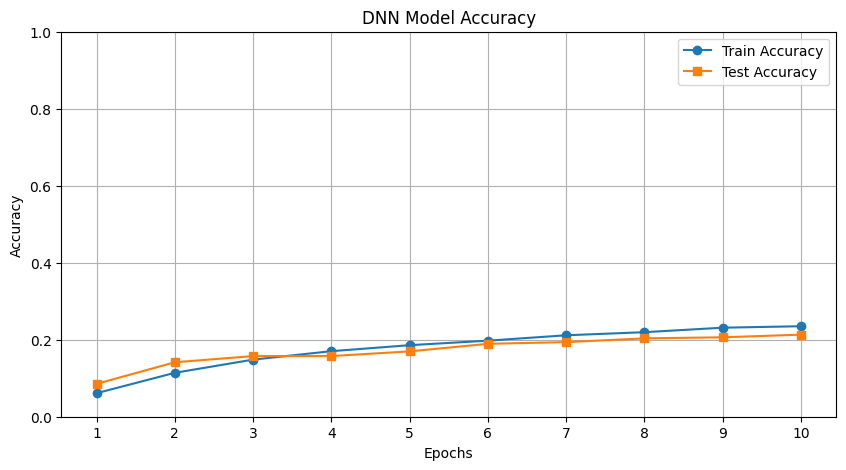

In [63]:
# plot train/test accuracy over epochs

plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS+1), train_acc_list_dnn, marker='o', label = "Train Accuracy")
plt.plot(range(1, EPOCHS+1), test_acc_list_dnn, marker='s', label = "Test Accuracy")
plt.title("DNN Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(range(1, EPOCHS+1))
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

Test Accuracy for DNN: 21.32
Test Loss for DNN: 3.2954


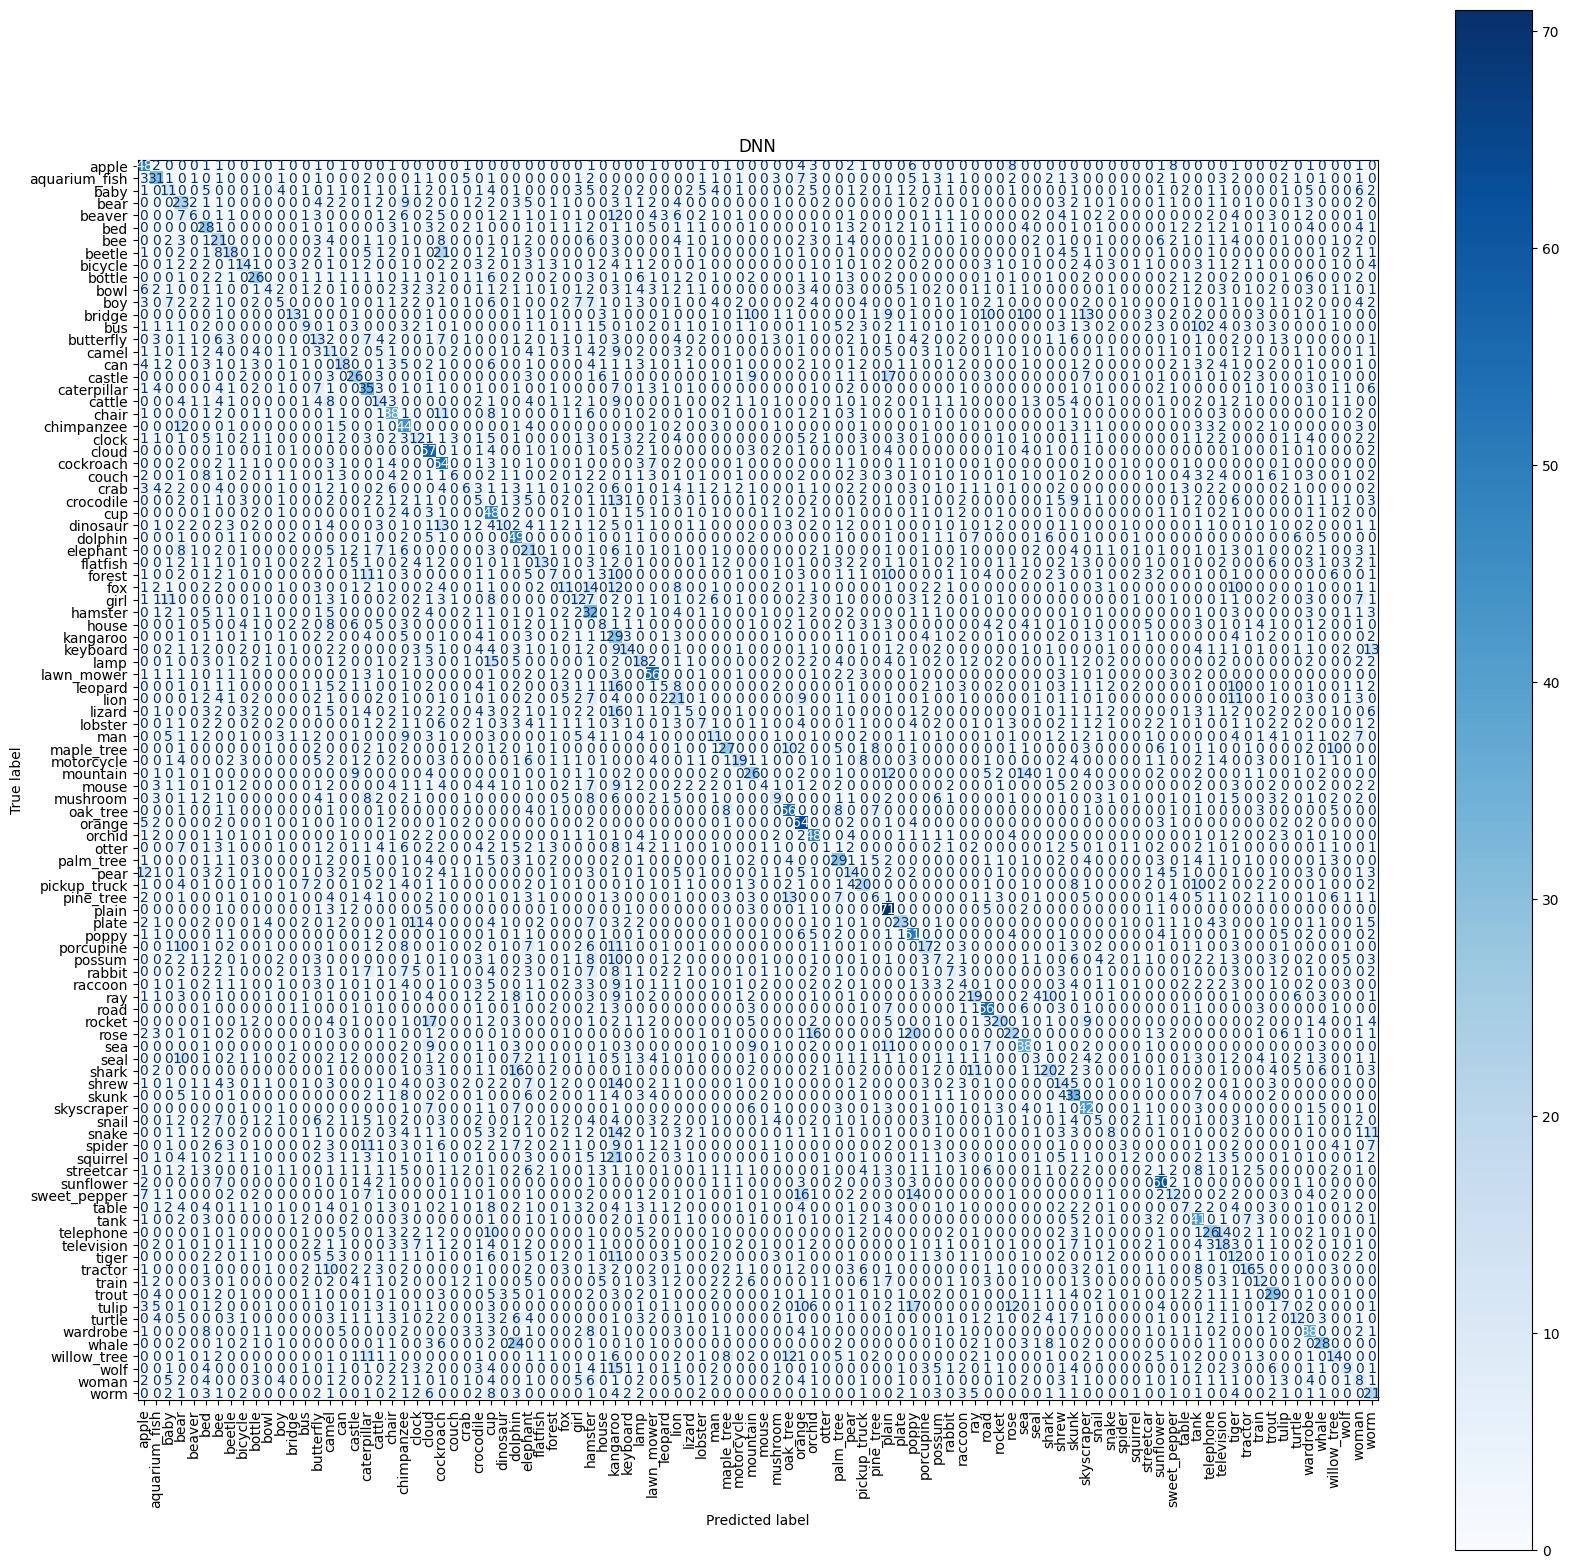

In [64]:
# Evaluate DNN test set- print test accuracy, loss,print confusion matrix

evaluate_and_plot(model_dnn, test_loader, classes, "DNN")

In [65]:
# save model weights

torch.save(model_dnn.state_dict(), "cifar100_dnn.pth")
print("DNN Model saved as cifar100_dnn.pth")

DNN Model saved as cifar100_dnn.pth


### b) Design a deep convolutions neural network (DCNN) with 4 convolutional layers for the following dataset - CIFAR-100

In [66]:
# CNN Model

class CIFAR100_CNN(nn.Module):
    def __init__(self):
        super(CIFAR100_CNN, self).__init__()

        # convolutional block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),     # normalize
            nn.ReLU(),

            nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size = 2, stride = 2)   # downsample - 32 to 16
        )

        # convolutional block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size = 2, stride = 2)   # downsample - 16 to 8
        )

        # fully connected classifier
        self.fc = nn.Sequential(
            nn.Linear(64 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 100)     # output
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [67]:
# create model, loss function and optimizer

cnn_model = CIFAR100_CNN().to(device)
loss_fn_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr = 0.001)

In [68]:
# Train CNN for several epochs

train_acc_list_cnn = []
test_acc_list_cnn = []

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(cnn_model, train_loader, loss_fn_cnn, optimizer_cnn)
    test_loss, test_acc = evaluate(cnn_model, test_loader, loss_fn_cnn)

    # record train/test accuracies for each epoch
    train_acc_list_cnn.append(train_acc)
    test_acc_list_cnn.append(test_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    print("-----------------------------------------------------")


Epoch 1/10
Train Loss: 4.0559, Train Accuracy: 0.0715
Test Loss: 3.5880, Test Accuracy: 0.1461
-----------------------------------------------------
Epoch 2/10
Train Loss: 3.5573, Train Accuracy: 0.1469
Test Loss: 3.2850, Test Accuracy: 0.1986
-----------------------------------------------------
Epoch 3/10
Train Loss: 3.2743, Train Accuracy: 0.1918
Test Loss: 2.9336, Test Accuracy: 0.2731
-----------------------------------------------------
Epoch 4/10
Train Loss: 3.0320, Train Accuracy: 0.2331
Test Loss: 2.7025, Test Accuracy: 0.3242
-----------------------------------------------------
Epoch 5/10
Train Loss: 2.8329, Train Accuracy: 0.2699
Test Loss: 2.5777, Test Accuracy: 0.3383
-----------------------------------------------------
Epoch 6/10
Train Loss: 2.6680, Train Accuracy: 0.2997
Test Loss: 2.4344, Test Accuracy: 0.3666
-----------------------------------------------------
Epoch 7/10
Train Loss: 2.5506, Train Accuracy: 0.3238
Test Loss: 2.4617, Test Accuracy: 0.3613
-----------

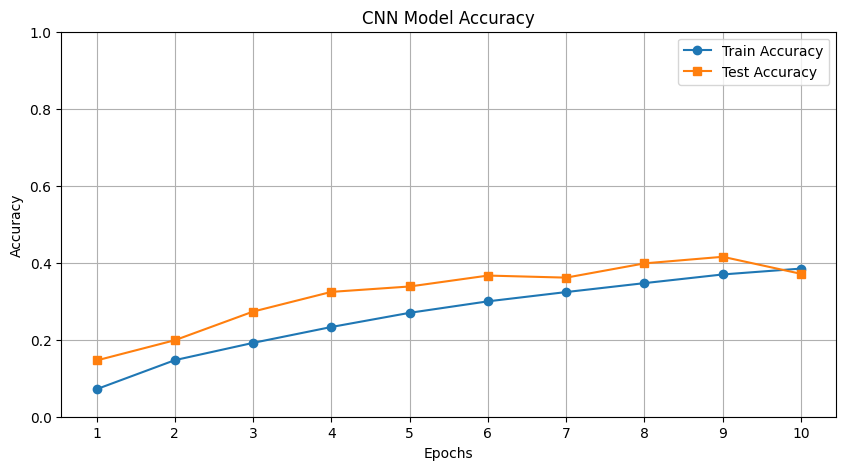

In [69]:
# plot train/test accuracy over epochs

plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS+1), train_acc_list_cnn, marker='o', label = "Train Accuracy")
plt.plot(range(1, EPOCHS+1), test_acc_list_cnn, marker='s', label = "Test Accuracy")
plt.title("CNN Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(range(1, EPOCHS+1))
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

Test Accuracy for CNN: 37.11
Test Loss for CNN: 2.4418


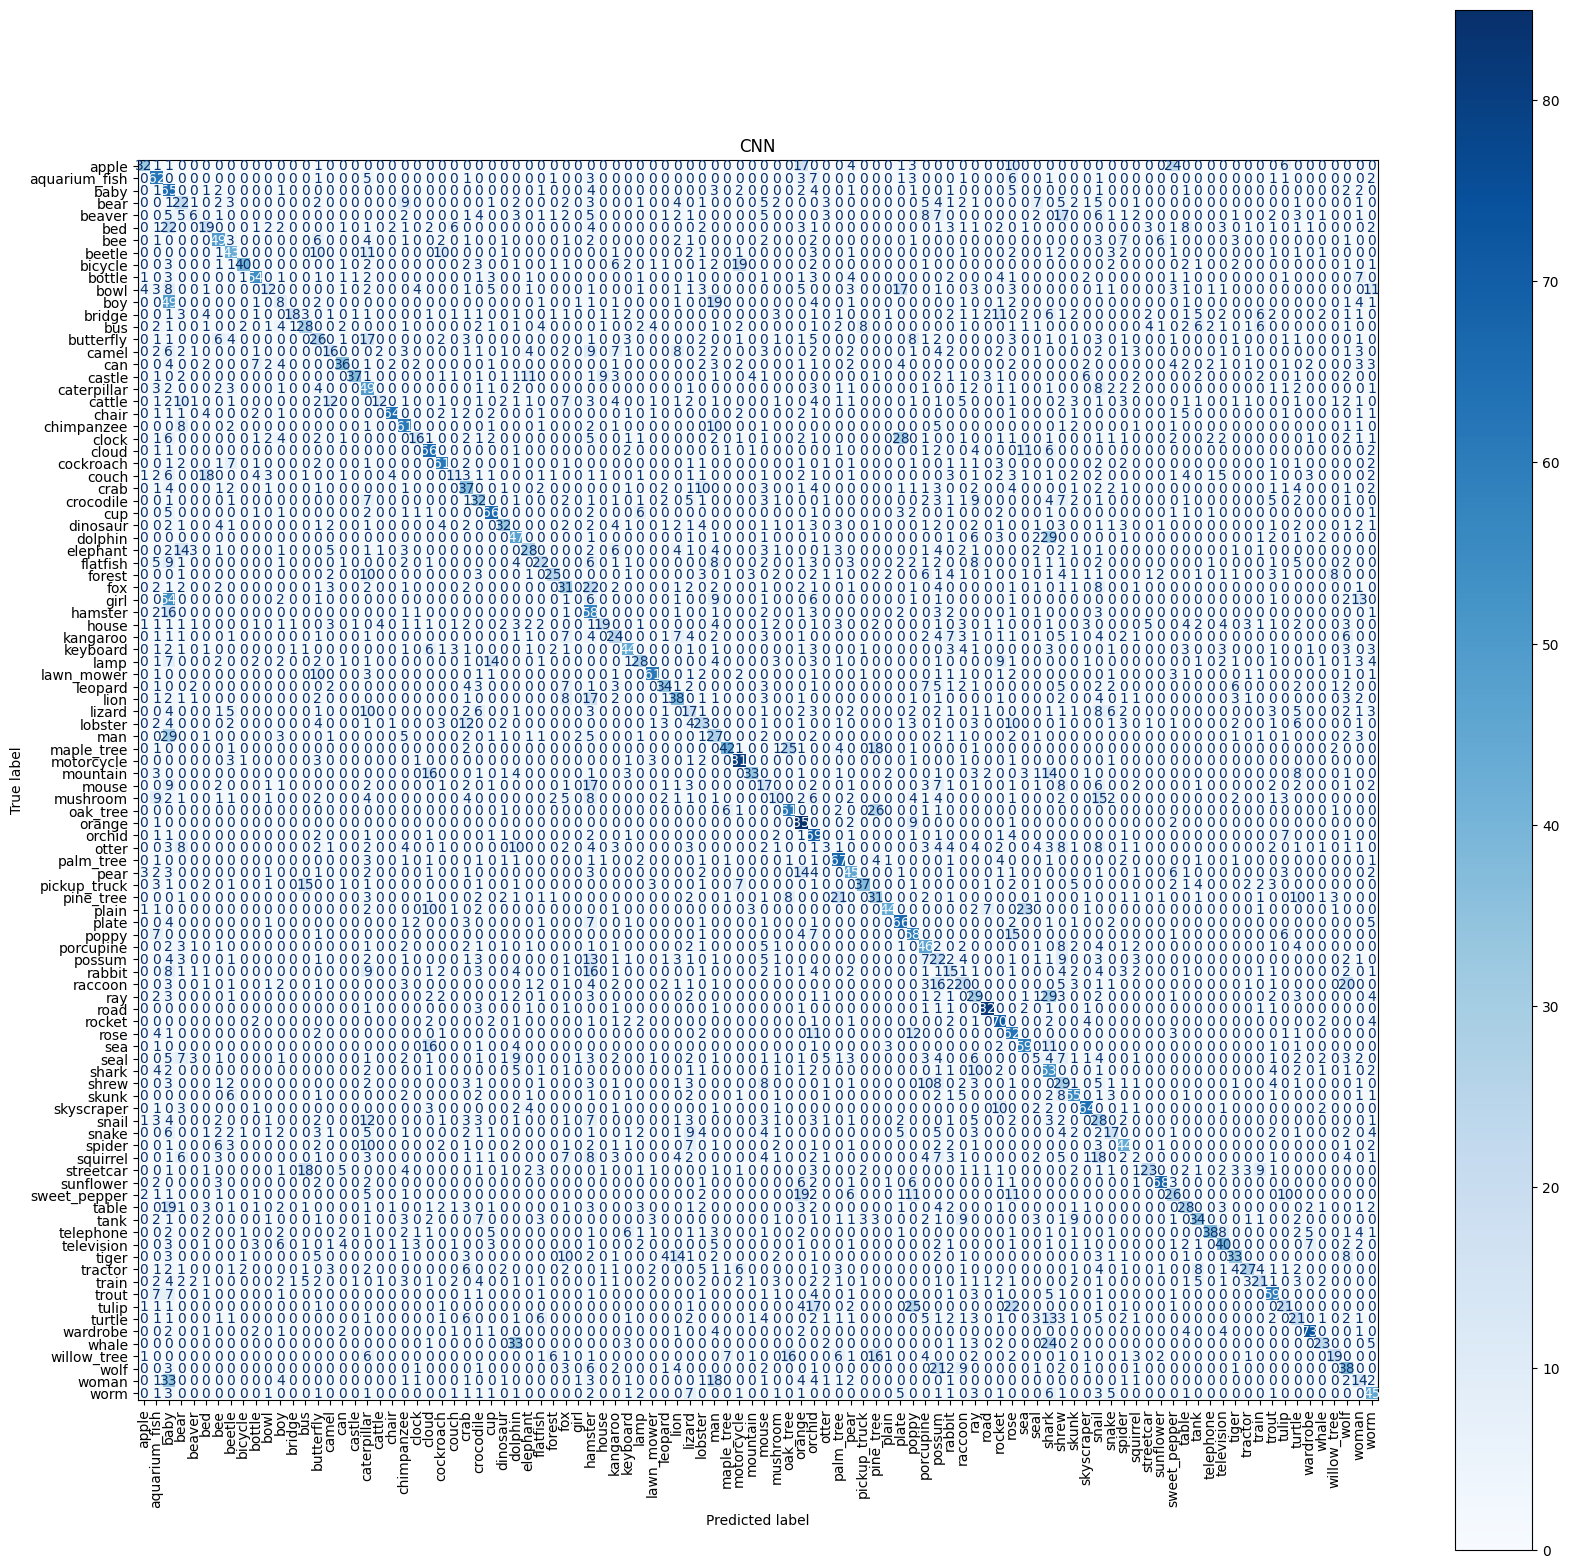

In [70]:
# Evalute CNN test set- print test accuracy, loss and confusion matrix

evaluate_and_plot(cnn_model, test_loader, classes, "CNN")

In [71]:
# save CNN model weights
torch.save(cnn_model.state_dict(), "cifar100_cnn.pth")
print("CNN weights saved as cifar100_cnn.pth")

CNN weights saved as cifar100_cnn.pth


### c) Try to improve the performance of the DNN and DCNN by using transfer learning, data augmentation techniques

In [72]:
# Data augmentation for training

# defining transformation for training
train_transform_aug = transforms.Compose([
    # flip image horizontally
    transforms.RandomHorizontalFlip(),
    # random cropping with padding
    transforms.RandomCrop(32, padding = 4),
    # random brightness/ contrast
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2),
    transforms.ToTensor(),
    # CIFAR-100 mean/std
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])

# defining transformation for testing images
test_transform_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [73]:
# Load CIFAR-100 datasets

train_dataset_aug = datasets.CIFAR100(root='./data', train = True, download = True, transform=train_transform_aug)
test_dataset_aug = datasets.CIFAR100(root='./data', train = False, download = True, transform=test_transform_aug)

train_loader_aug = DataLoader(train_dataset_aug, batch_size = 128, shuffle = True, num_workers = 2)
test_loader_aug = DataLoader(test_dataset_aug, batch_size = 128, shuffle = False, num_workers = 2)


In [74]:
# Initialize DNN, loss function and optimizer for augmented dataset
dnn_model_aug = CIFAR100_DNN().to(device)
loss_fn_dnn_aug = nn.CrossEntropyLoss()
optimizer_dnn = optim.Adam(dnn_model_aug.parameters(), lr = 0.001)

# epochs to train
EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(dnn_model_aug, train_loader_aug, loss_fn_dnn_aug, optimizer_dnn)
    test_loss, test_acc = evaluate(dnn_model_aug, test_loader_aug, loss_fn_dnn_aug)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    print("-----------------------------------------------------")

# save model weights

torch.save(dnn_model_aug.state_dict(), "cifar100_dnn_aug.pth")
print("Augmented DNN Model saved as cifar100_dnn_aug.pth")

Epoch 1/10
Train Loss: 3.9990, Train Accuracy: 0.0887
Test Loss: 3.7797, Test Accuracy: 0.1205
-----------------------------------------------------
Epoch 2/10
Train Loss: 3.6792, Train Accuracy: 0.1379
Test Loss: 3.6263, Test Accuracy: 0.1439
-----------------------------------------------------
Epoch 3/10
Train Loss: 3.5393, Train Accuracy: 0.1601
Test Loss: 3.5433, Test Accuracy: 0.1639
-----------------------------------------------------
Epoch 4/10
Train Loss: 3.4386, Train Accuracy: 0.1774
Test Loss: 3.5242, Test Accuracy: 0.1708
-----------------------------------------------------
Epoch 5/10
Train Loss: 3.3607, Train Accuracy: 0.1923
Test Loss: 3.5105, Test Accuracy: 0.1812
-----------------------------------------------------
Epoch 6/10
Train Loss: 3.3005, Train Accuracy: 0.2004
Test Loss: 3.5513, Test Accuracy: 0.1772
-----------------------------------------------------
Epoch 7/10
Train Loss: 3.2569, Train Accuracy: 0.2107
Test Loss: 3.4803, Test Accuracy: 0.1845
-----------

Test Accuracy for DNN with Augmentation: 18.87
Test Loss for DNN with Augmentation: 3.4936


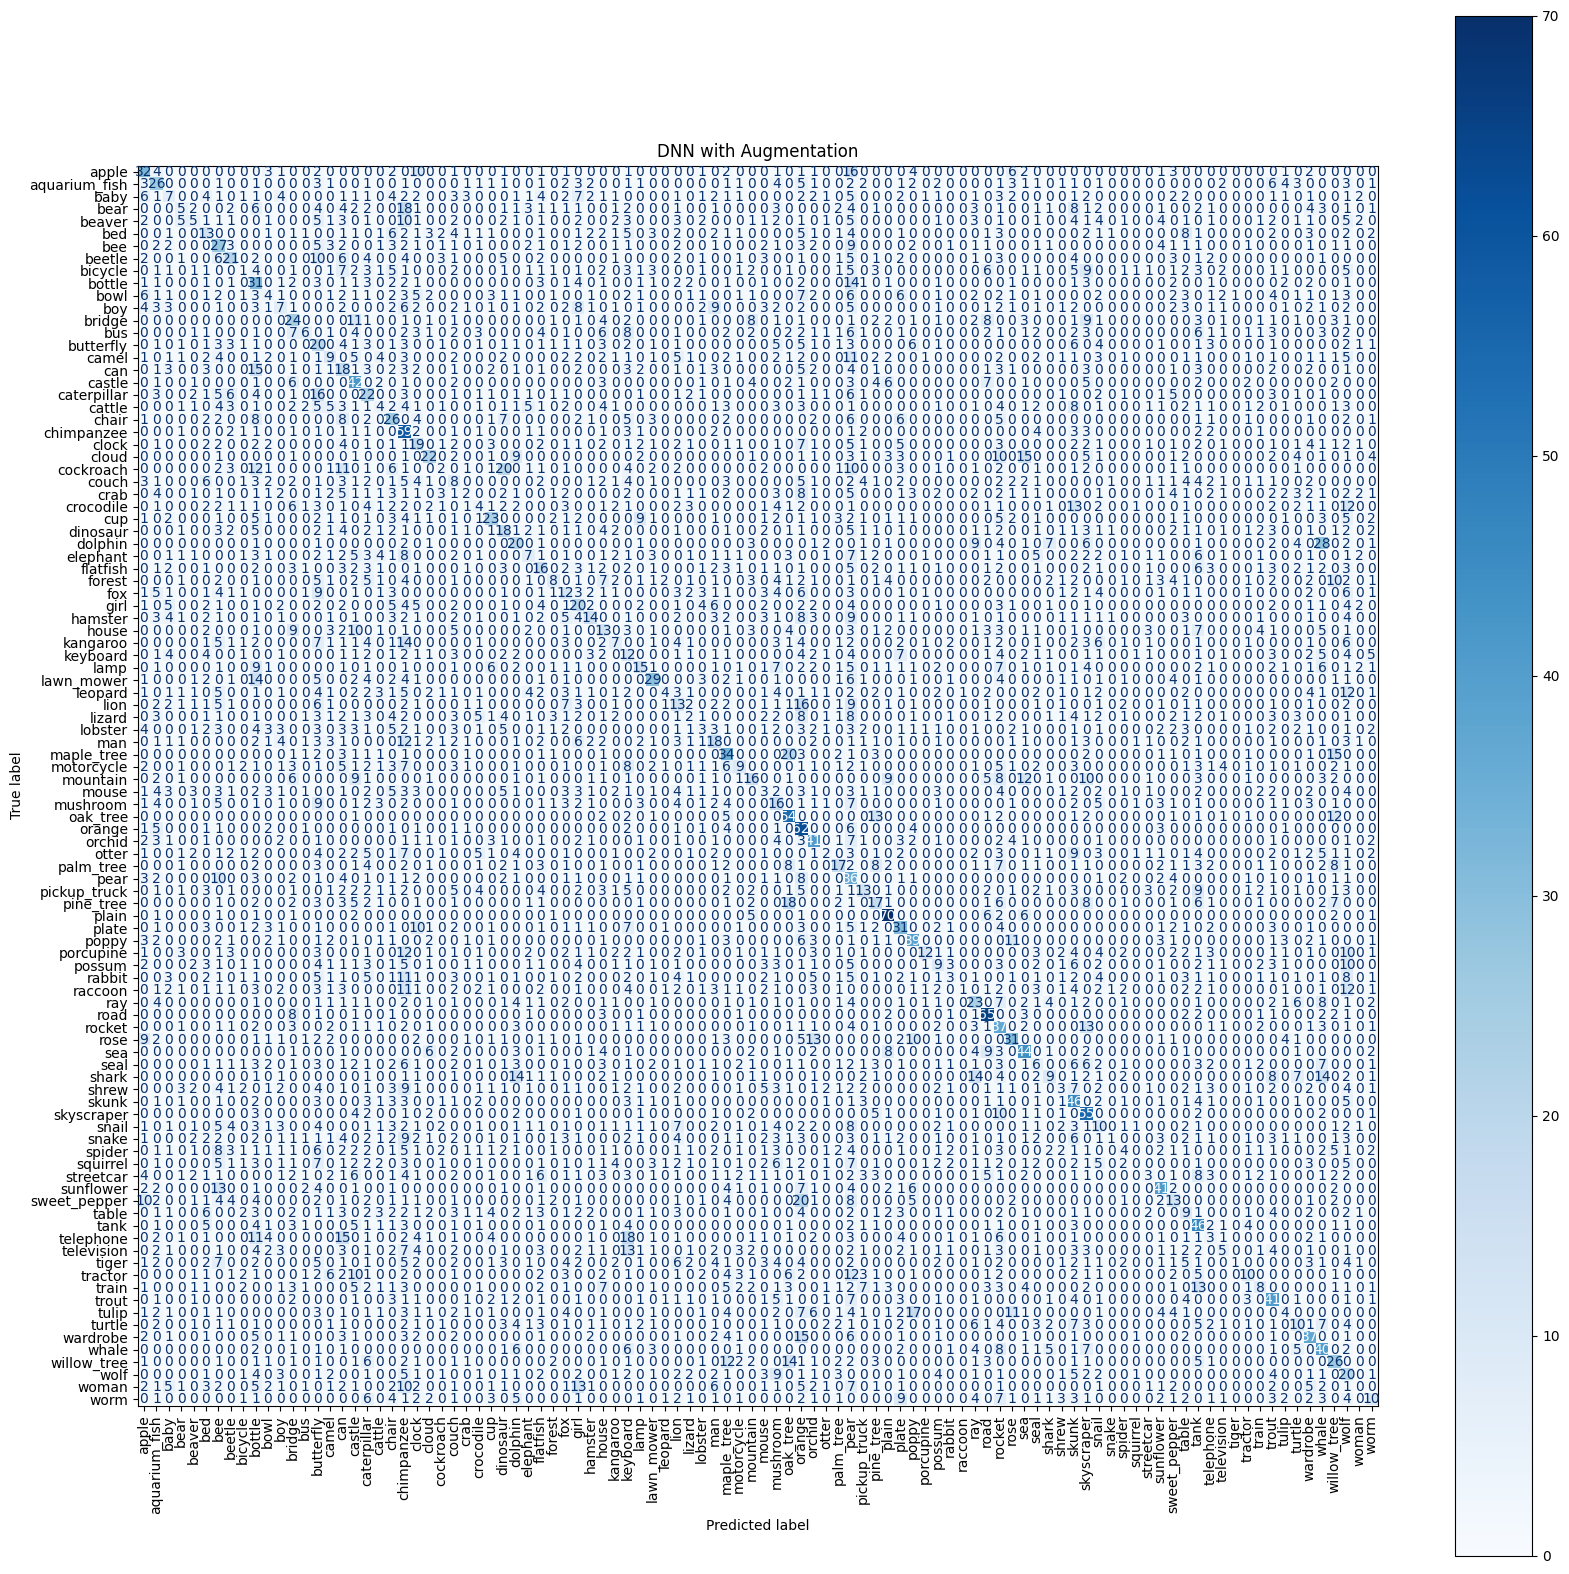

In [75]:
# Evaluate DNN aug test set- print test accuracy,loss and print confusion matrix

evaluate_and_plot(dnn_model_aug, test_loader_aug, classes, "DNN with Augmentation")

In [76]:
# initialize CNN, loss function and optimizer for augmented dataset

cnn_model_aug = CIFAR100_CNN().to(device)
loss_fn_cnn_aug = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn_model_aug.parameters(), lr = 0.001)

# epochs to train
EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(cnn_model_aug, train_loader_aug, loss_fn_cnn_aug, optimizer_cnn)
    test_loss, test_acc = evaluate(cnn_model_aug, test_loader_aug, loss_fn_cnn_aug)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    print("-----------------------------------------------------")

# save model weights

torch.save(cnn_model_aug.state_dict(), "cifar100_cnn_aug.pth")
print("Augmented CNN Model saved as cifar100_cnn_aug.pth")

Epoch 1/10
Train Loss: 4.1864, Train Accuracy: 0.0547
Test Loss: 3.7575, Test Accuracy: 0.1120
-----------------------------------------------------
Epoch 2/10
Train Loss: 3.7522, Train Accuracy: 0.1118
Test Loss: 3.3408, Test Accuracy: 0.1935
-----------------------------------------------------
Epoch 3/10
Train Loss: 3.5117, Train Accuracy: 0.1484
Test Loss: 3.0843, Test Accuracy: 0.2403
-----------------------------------------------------
Epoch 4/10
Train Loss: 3.3061, Train Accuracy: 0.1867
Test Loss: 2.8783, Test Accuracy: 0.2739
-----------------------------------------------------
Epoch 5/10
Train Loss: 3.1475, Train Accuracy: 0.2115
Test Loss: 2.7694, Test Accuracy: 0.2960
-----------------------------------------------------
Epoch 6/10
Train Loss: 3.0225, Train Accuracy: 0.2349
Test Loss: 2.5401, Test Accuracy: 0.3276
-----------------------------------------------------
Epoch 7/10
Train Loss: 2.8967, Train Accuracy: 0.2589
Test Loss: 2.5238, Test Accuracy: 0.3376
-----------

Test Accuracy for CNN with Augmentation: 39.42
Test Loss for CNN with Augmentation: 2.2618


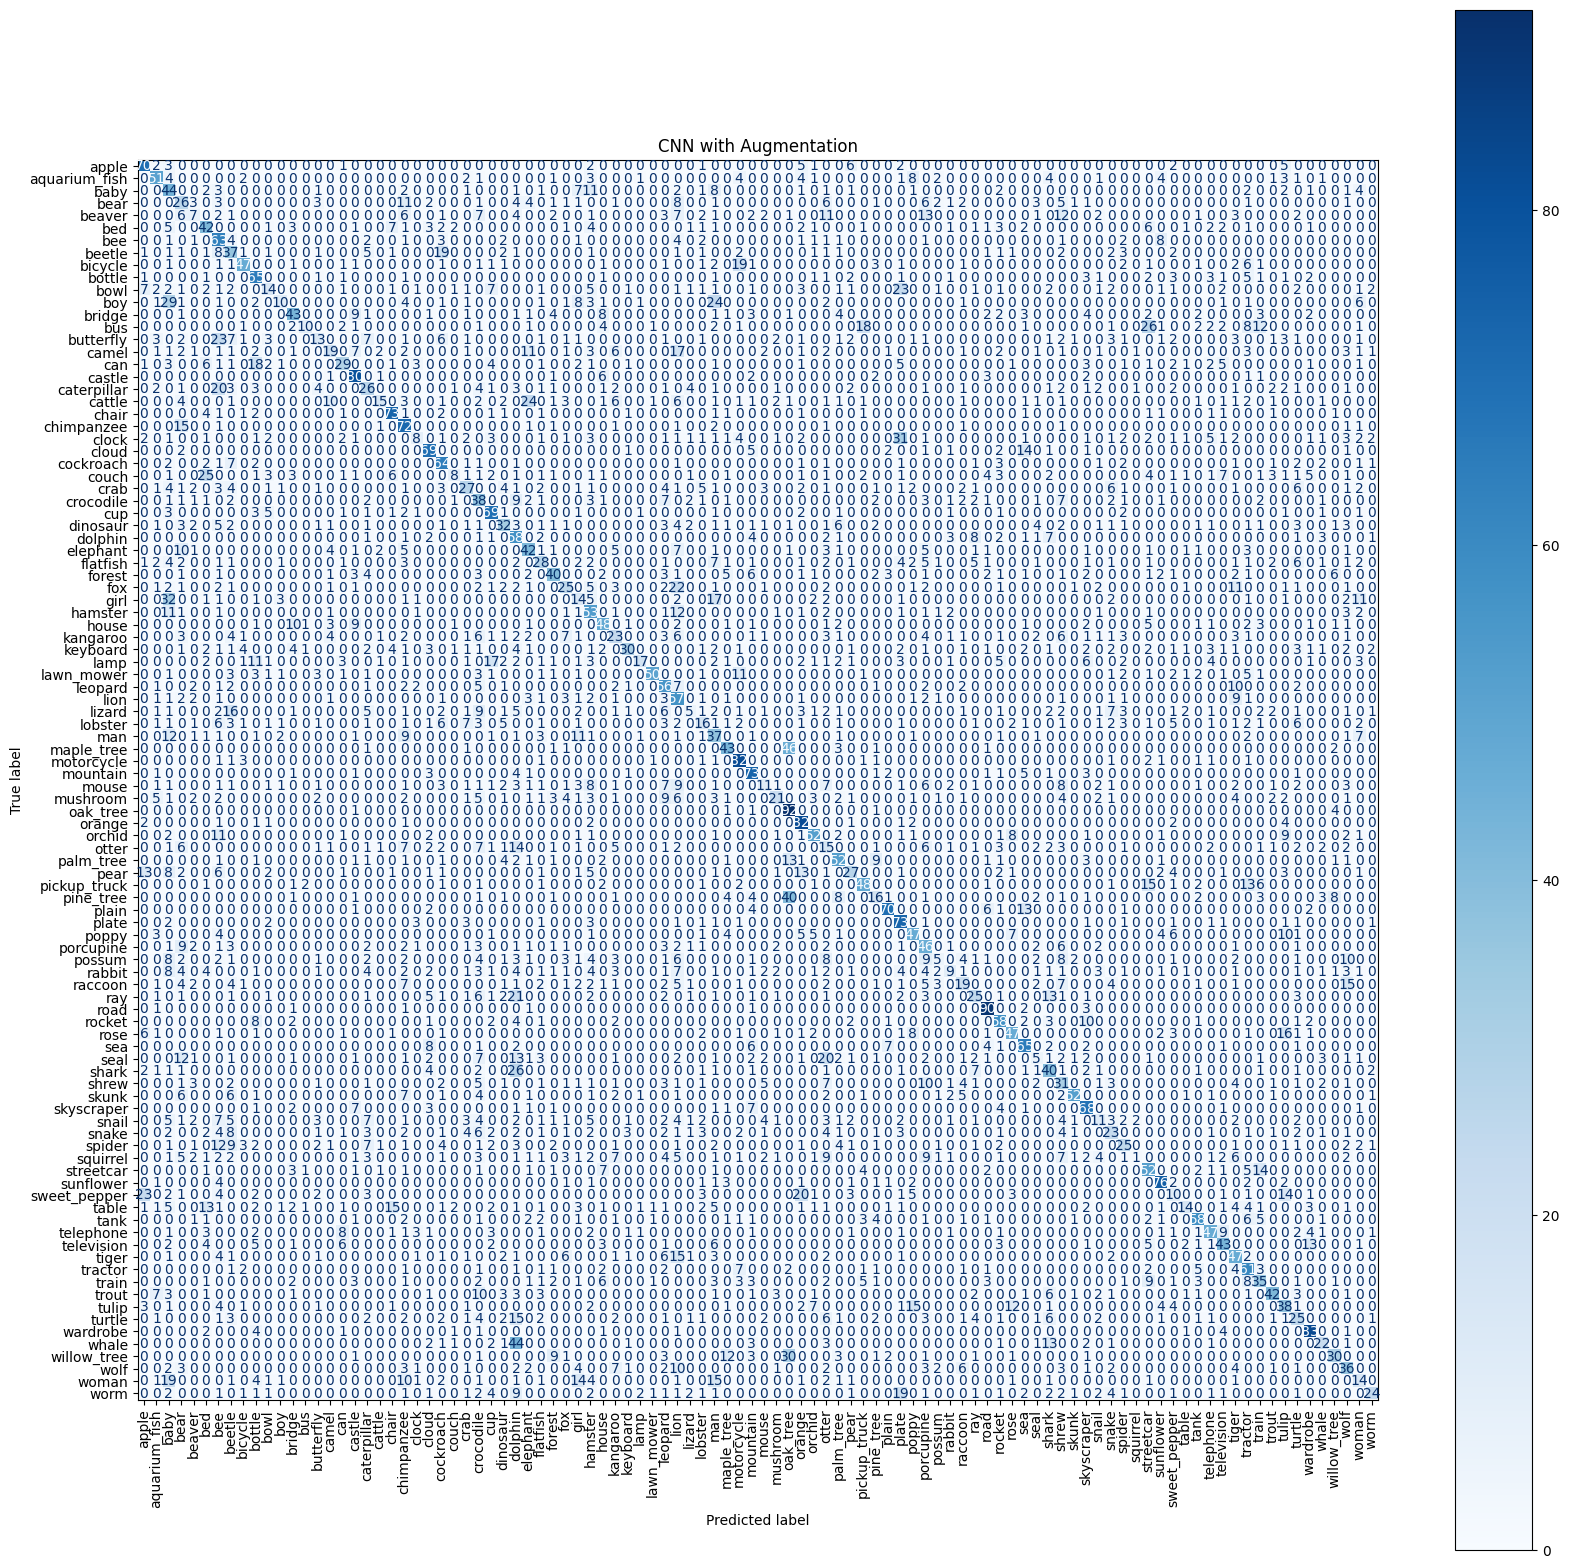

In [77]:
# Evaluate CNN aug test set- print test accuracy,loss and print confusion matrix

evaluate_and_plot(cnn_model_aug, test_loader_aug, classes, "CNN with Augmentation")

In [78]:
# Transfer Learning

# load a pretrained Resnet-18
resnet = models.resnet18(pretrained = True)

# replacing the final fully connected layer with CIFAR-100 output
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 100)

# move to device
resnet = resnet.to(device)

# define loss function and optimizer
loss_fn_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet.parameters(), lr = 0.001)

# Training loop
EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(resnet, train_loader_aug, loss_fn_resnet, optimizer_resnet)
    test_loss, test_acc = evaluate(resnet, test_loader_aug, loss_fn_resnet)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    print("-----------------------------------------------------")

torch.save(resnet.state_dict(), "cifar100_resnet.pth")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
Train Loss: 2.9973, Train Accuracy: 0.2631
Test Loss: 2.4866, Test Accuracy: 0.3681
-----------------------------------------------------
Epoch 2/10
Train Loss: 2.2958, Train Accuracy: 0.3938
Test Loss: 2.3805, Test Accuracy: 0.3897
-----------------------------------------------------
Epoch 3/10
Train Loss: 2.0527, Train Accuracy: 0.4487
Test Loss: 2.0116, Test Accuracy: 0.4631
-----------------------------------------------------
Epoch 4/10
Train Loss: 1.8970, Train Accuracy: 0.4822
Test Loss: 1.9680, Test Accuracy: 0.4798
-----------------------------------------------------
Epoch 5/10
Train Loss: 1.7818, Train Accuracy: 0.5053
Test Loss: 1.8194, Test Accuracy: 0.5080
-----------------------------------------------------
Epoch 6/10
Train Loss: 1.6784, Train Accuracy: 0.5304
Test Loss: 1.8141, Test Accuracy: 0.5098
-----------------------------------------------------
Epoch 7/10
Train Loss: 1.5987, Train Accuracy: 0.5513
Test Loss: 1.7488, Test Accuracy: 0.5245
-----------

Test Accuracy for Resnet Transfer Learning: 54.96
Test Loss for Resnet Transfer Learning: 1.6876


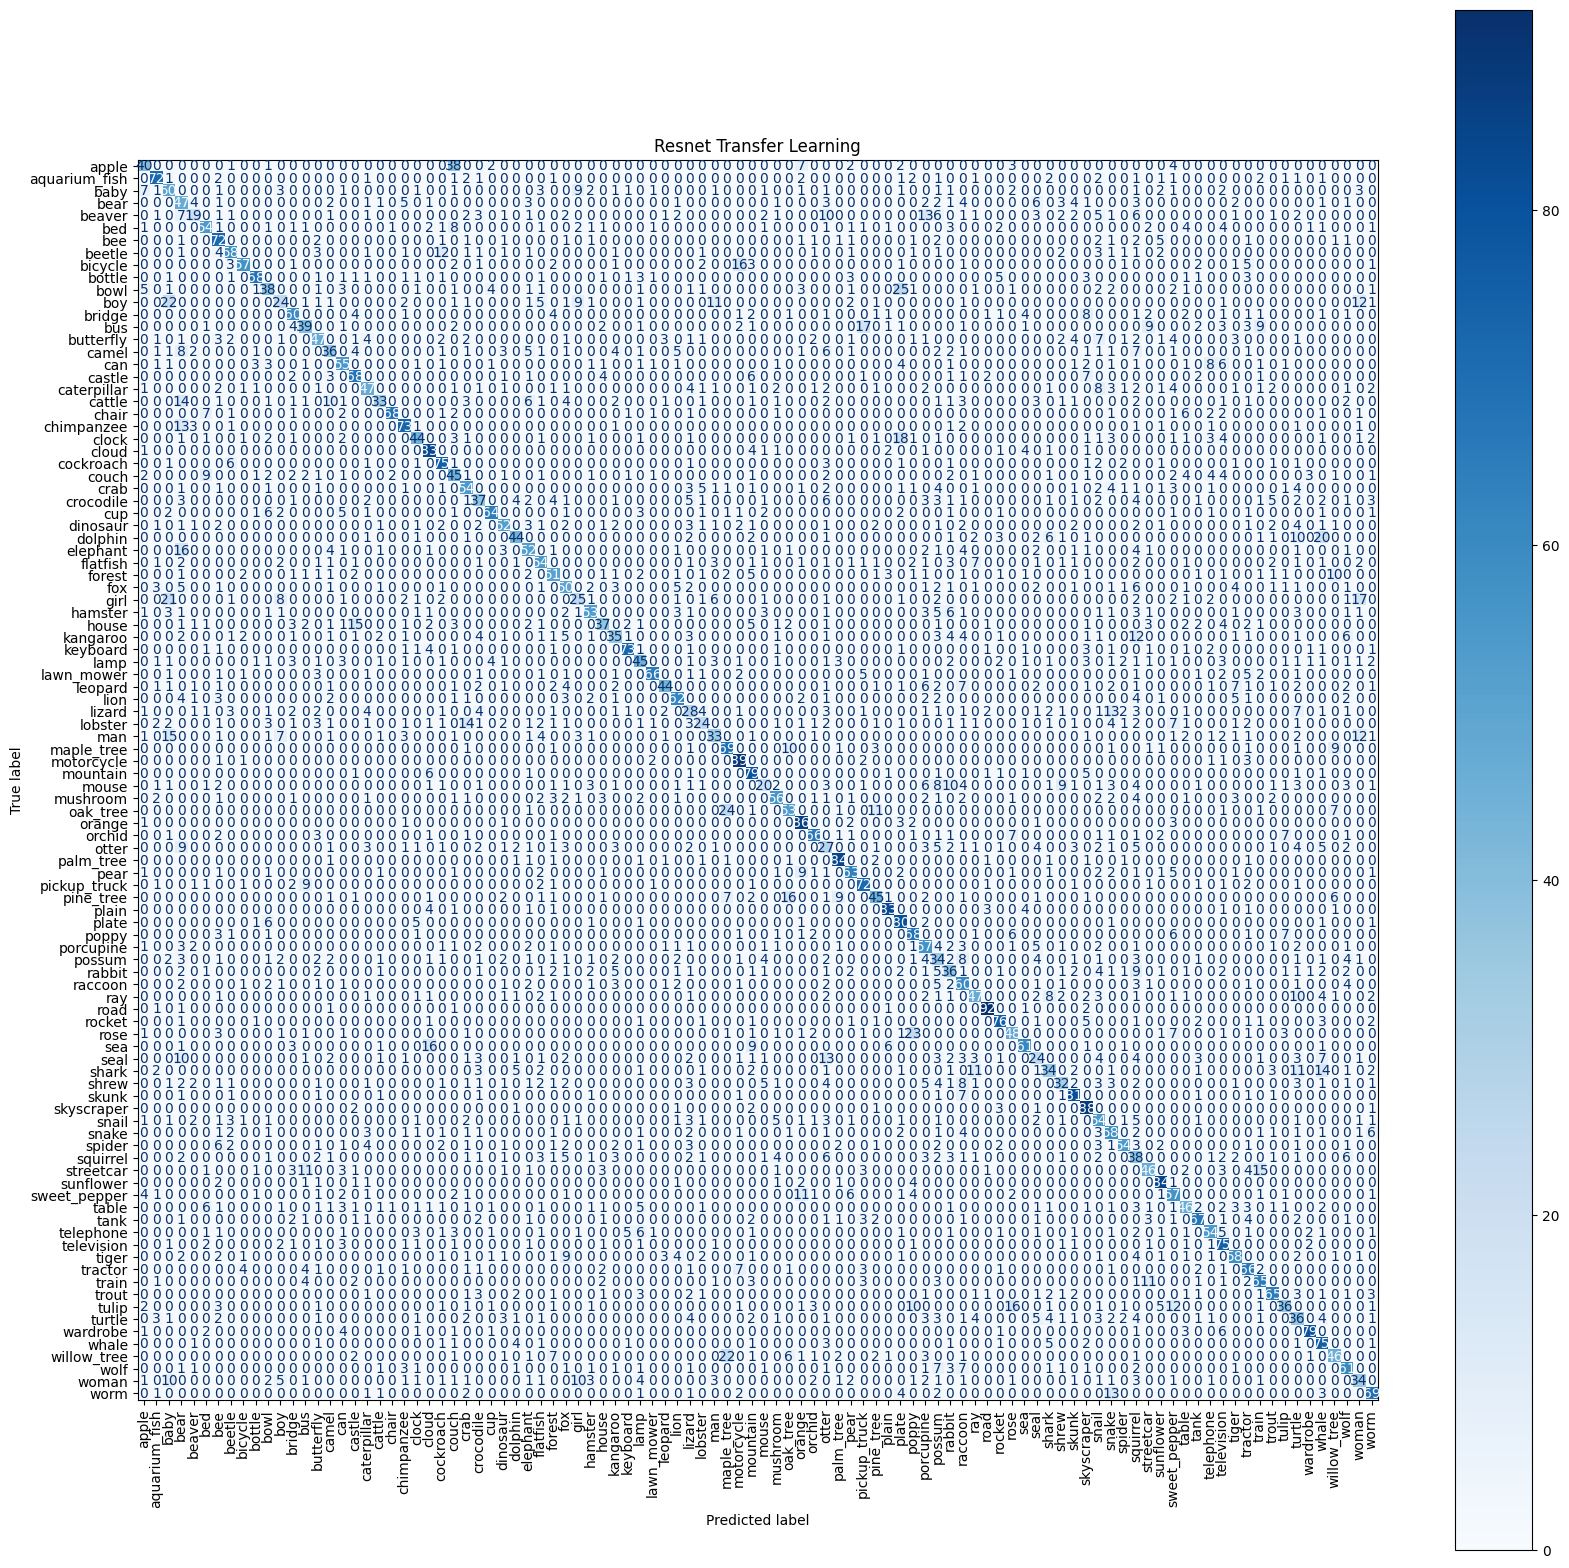

In [79]:
# Evaluate Resnet test set- print test accuracy,loss and print confusion matrix

evaluate_and_plot(resnet, test_loader_aug, classes, "Resnet Transfer Learning")

### d) Interpret the learned model decision using Captum or another library.

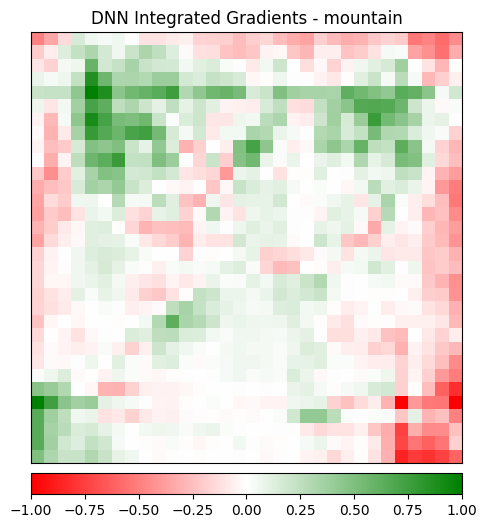

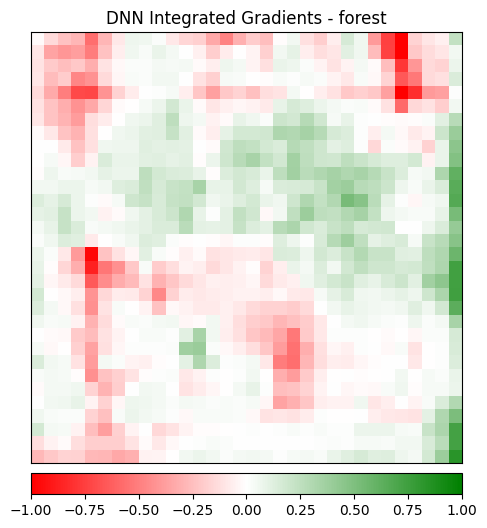

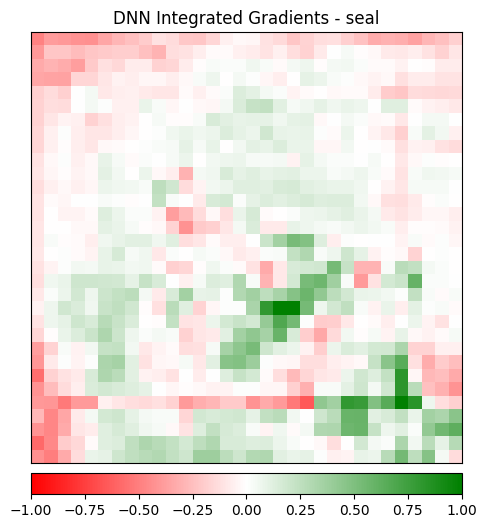

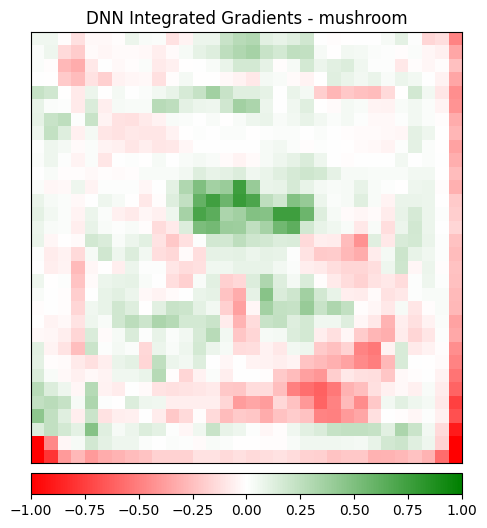

In [80]:
# DNN transfer learning model with Integrated Gradients

# put DNN model in evaluation model
dnn_model_aug.eval()

# get a batch of test images
images, labels = next(iter(test_loader_aug))
# move images to GPU
images, labels = images.to(device), labels.to(device)


# initialize Captum Integrated Grandients with the trained DNN model
ig = IntegratedGradients(dnn_model_aug)

for i in range(4):

    # selecting one images and target class
    input_img = images[i].unsqueeze(0)
    target_class = labels[i].item()

    # compute IG attributions
    attributions, delta = ig.attribute(input_img, target=target_class, return_convergence_delta=True)

    # convert image and attributions
    img = input_img[0].cpu().numpy().transpose(1, 2, 0)
    img = (img * 0.5) + 0.5
    attr = attributions[0].detach().cpu().numpy().transpose(1, 2, 0)

    # visualize attribution heat map
    viz.visualize_image_attr(attr, img, method="heat_map",
                            sign="all", show_colorbar=True,
                            title=f"DNN Integrated Gradients - {classes[target_class]}")


/usr/local/lib/python3.12/dist-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


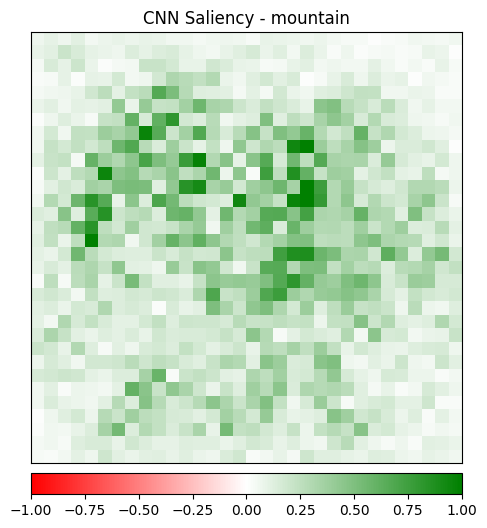

/usr/local/lib/python3.12/dist-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


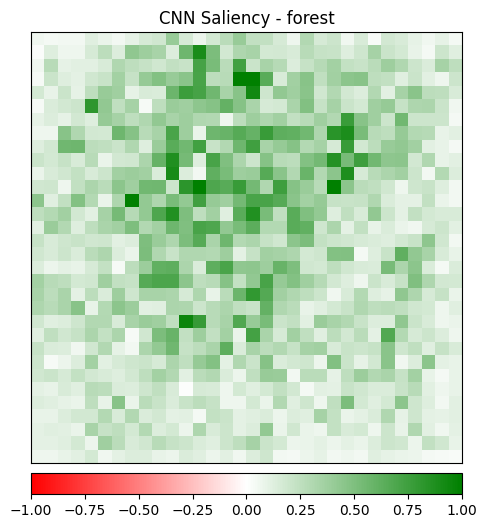

/usr/local/lib/python3.12/dist-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


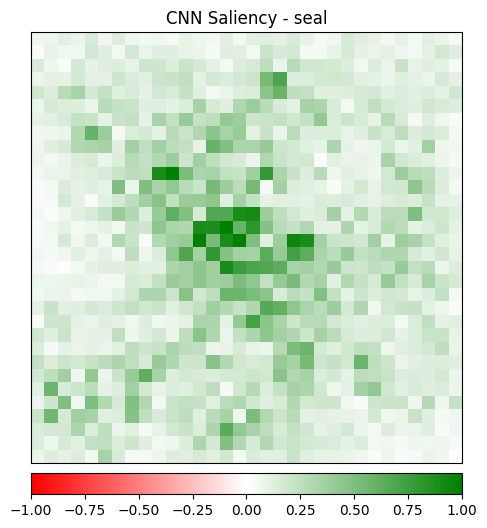

/usr/local/lib/python3.12/dist-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


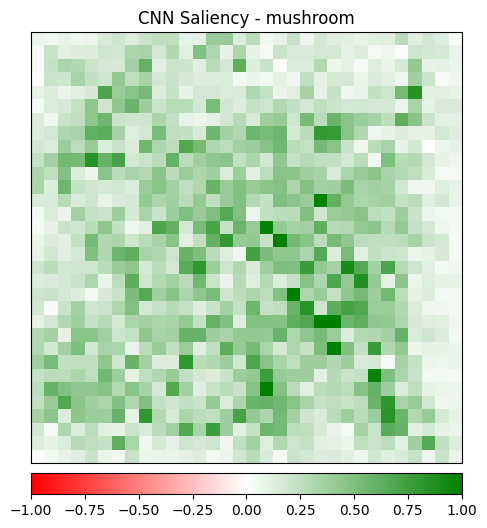

In [81]:
# CNN transfer learning model with Saliency maps

# put CNN model in evaluation mode
cnn_model_aug.eval()

# get a batch of test images
images, labels = next(iter(test_loader_aug))
# move images to GPU
images, labels = images.to(device), labels.to(device)

# initialize Captum saliency
saliency = Saliency(cnn_model_aug)

# for first 4 images

for i in range(4):

    input_img = images[i].unsqueeze(0)
    target_class = labels[i].item()

    # compute saliency map
    saliency_map = saliency.attribute(input_img, target=target_class)

    # convert image and saliency map to numpy
    img = input_img[0].cpu().numpy().transpose(1, 2, 0)
    img = (img * 0.5) + 0.5
    saliency_map = saliency_map[0].detach().cpu().numpy().transpose(1, 2, 0)

    # visualize saliency map as heatmap
    viz.visualize_image_attr(saliency_map, img, method="heat_map",
                             sign = "all", show_colorbar = True,
                             title = f"CNN Saliency - {classes[target_class]}")


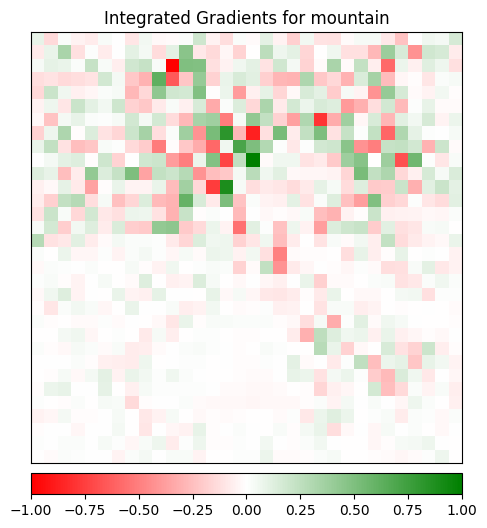

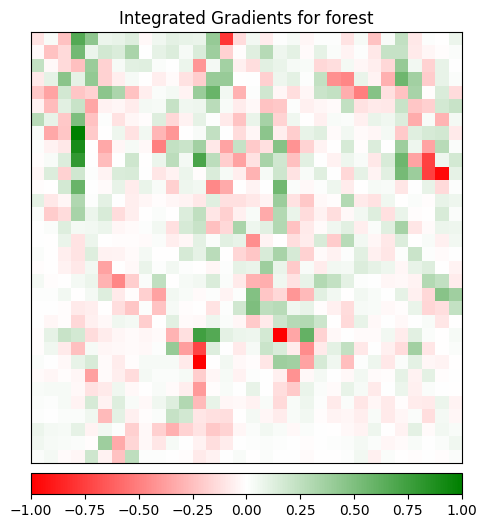

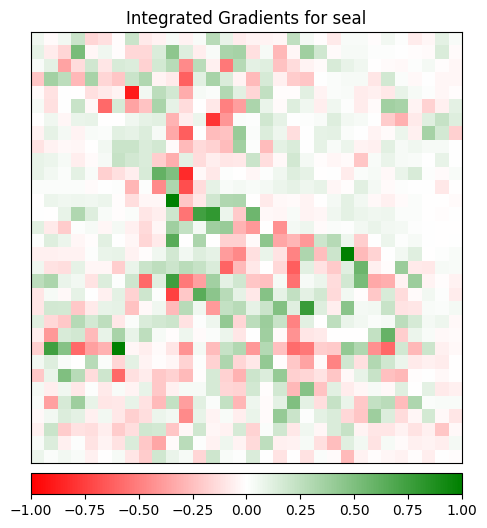

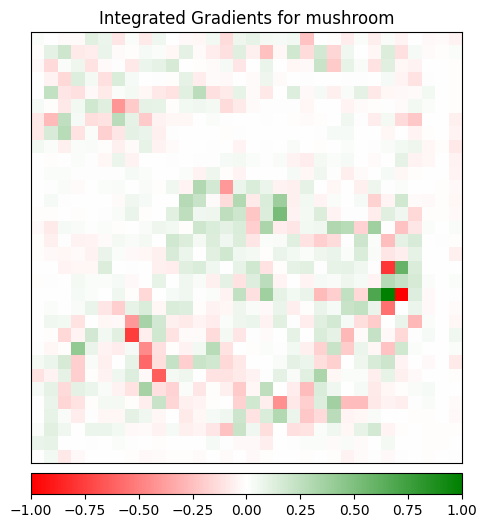

In [82]:
# Resnet transfer learning model with Integrated Gradients
# resnet model in evaluation mode
resnet.eval()

# get a batch of test images
images, labels = next(iter(test_loader_aug))
# move images to GPU
images, labels = images.to(device), labels.to(device)

# initialize the attribution method and pass the model to it
ig = IntegratedGradients(resnet)

# visualization with captum
for i in range(4):
    # pick an image and target class
    input_img = images[i].unsqueeze(0)
    target_class = labels[i].item()

    # compute attributions
    attributions, delta = ig.attribute(input_img, target=target_class, return_convergence_delta=True)

    # visualize attributions
    img = input_img[0].cpu().numpy().transpose(1, 2, 0)
    img = (img * 0.5) + 0.5

    # convert attributions to numpy
    attr = attributions[0].detach().cpu().numpy().transpose(1, 2, 0)

    # visualize heatmap
    viz.visualize_image_attr(attr, img, method="heat_map", sign="all", title=f"Integrated Gradients for {classes[target_class]}", show_colorbar=True)


/usr/local/lib/python3.12/dist-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


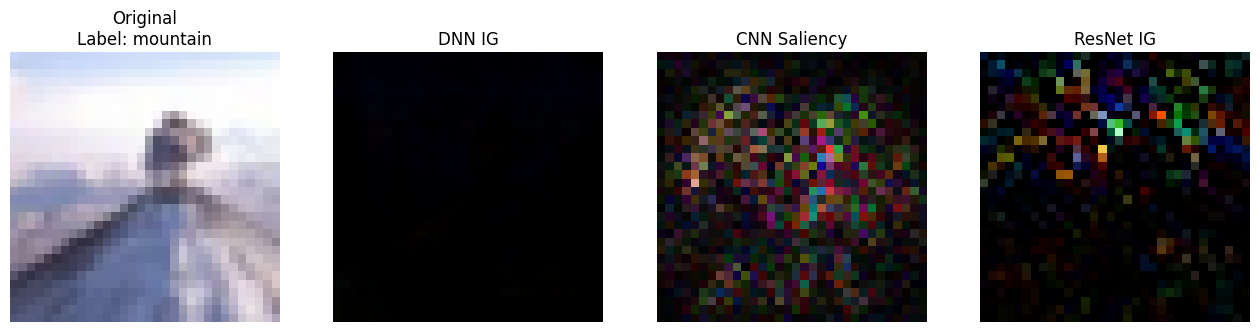

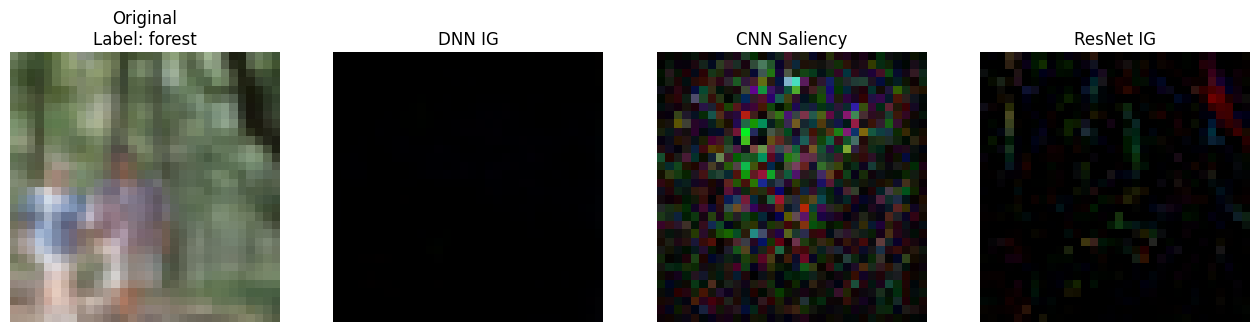

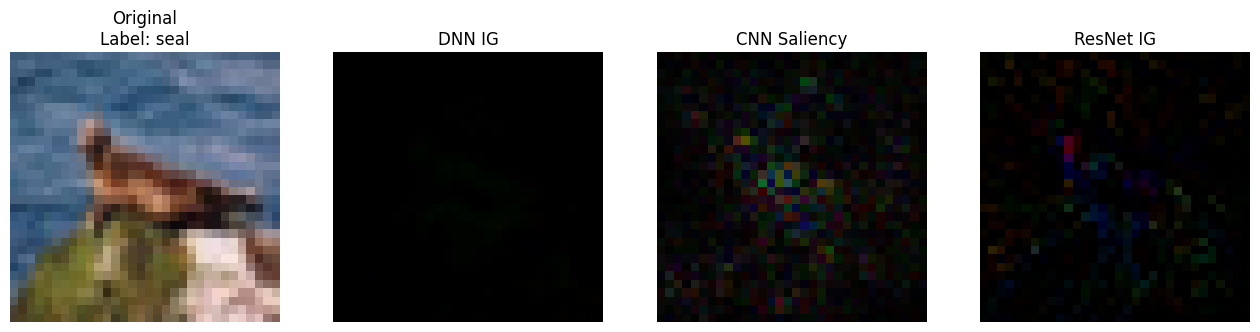

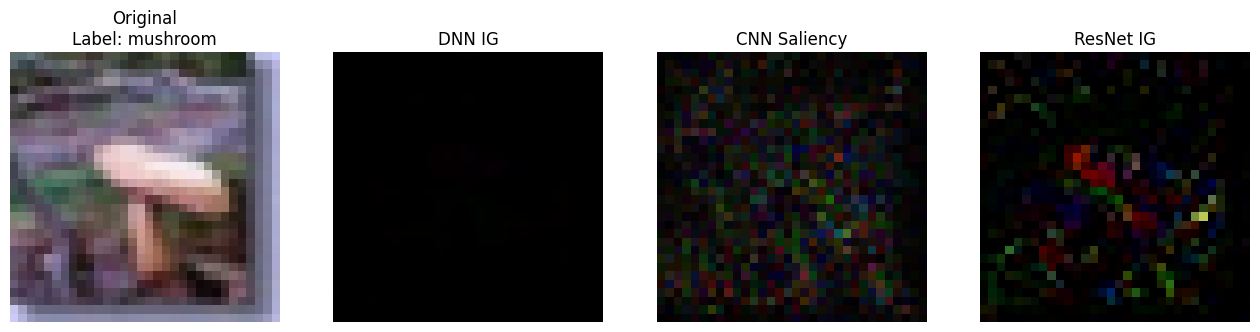

In [83]:
# Take a batch of test images
images, labels = next(iter(test_loader_aug))
images, labels = images.to(device), labels.to(device)

# Pick number of images to visualize
num_images = 4

# Initialize attribution methods
ig_dnn = IntegratedGradients(dnn_model_aug)
saliency_cnn = Saliency(cnn_model_aug)
ig_resnet = IntegratedGradients(resnet)

for i in range(num_images):
    input_img = images[i].unsqueeze(0)
    target_class = labels[i].item()

    # --- DNN attribution ---
    attr_dnn, _ = ig_dnn.attribute(input_img, target=target_class, return_convergence_delta=True)
    attr_dnn = attr_dnn[0].detach().cpu().numpy().transpose(1, 2, 0)

    # --- CNN attribution ---
    attr_cnn = saliency_cnn.attribute(input_img, target=target_class)
    attr_cnn = attr_cnn[0].detach().cpu().numpy().transpose(1, 2, 0)

    # --- ResNet attribution ---
    attr_resnet, _ = ig_resnet.attribute(input_img, target=target_class, return_convergence_delta=True)
    attr_resnet = attr_resnet[0].detach().cpu().numpy().transpose(1, 2, 0)

    # Convert input image to numpy for visualization
    img_np = input_img[0].cpu().numpy().transpose(1, 2, 0)
    img_np = (img_np * 0.5) + 0.5  # undo normalization

    # Plot side by side
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(img_np)
    axs[0].set_title(f"Original\nLabel: {classes[target_class]}")
    axs[0].axis('off')

    axs[1].imshow(attr_dnn, cmap='hot')
    axs[1].set_title("DNN IG")
    axs[1].axis('off')

    axs[2].imshow(attr_cnn, cmap='hot')
    axs[2].set_title("CNN Saliency")
    axs[2].axis('off')

    axs[3].imshow(attr_resnet, cmap='hot')
    axs[3].set_title("ResNet IG")
    axs[3].axis('off')

    plt.show()
